In [1]:
import argparse
import os
import os.path as osp
import shutil
import time
import warnings

import mmcv
import torch
from mmcv.cnn.utils import revert_sync_batchnorm
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)

from mmseg.datasets.custom import CustomDataset
from mmseg.datasets.builder import DATASETS
from mmcv.utils import DictAction
from pathlib import Path
from mmseg import digit_version
from mmseg.apis import multi_gpu_test, single_gpu_test
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.utils import setup_multi_processes

from FoodDataset import FoodDataset

In [4]:
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())

WORK_DIR = "../checkpoints/swim_seg"
CONFIG_PTH = WORK_DIR + "/upernet_swin_small_patch4_window7_512x1024_80k.py.."
SHOW_DIR = WORK_DIR + "/painted" + timestamp
CHECKPOINT_PTH = "../checkpoints/swim_seg/iter_80000.pth"

print("Working Location: ", os.path.abspath(WORK_DIR))
print("Config Location: ", os.path.abspath(CONFIG_PTH))
print("Checkpoint Location: ", os.path.abspath(CHECKPOINT_PTH))

Working Location:  C:\Users\localadmin\Documents\btsai-dev-repositories\Food-Detection\checkpoints\swim_seg
Config Location:  C:\Users\localadmin\Documents\btsai-dev-repositories\Food-Detection\checkpoints\swim_seg\upernet_swin_small_patch4_window7_512x1024_80k.py
Checkpoint Location:  C:\Users\localadmin\Documents\btsai-dev-repositories\Food-Detection\checkpoints\swim_seg\iter_80000.pth


In [6]:
cfg = mmcv.Config.fromfile(CONFIG_PTH)
setup_multi_processes(cfg)
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True
    
cfg.model.pretrained = None
cfg.data.test.test_mode = True
cfg.gpu_ids = cfg.gpu_ids[0:1]

2022-03-03 19:48:04,700 - mmseg - INFO - OpenCV num_threads is `<built-in function getNumThreads>


In [10]:
rank, _ = get_dist_info()
mmcv.mkdir_or_exist(osp.abspath(WORK_DIR))

json_file = osp.join(WORK_DIR,
                     f'eval_single_scale_{timestamp}.json')
if rank == 0:
    work_dir = osp.join('./work_dirs', osp.splitext(osp.basename(CONFIG_PTH))[0])
    mmcv.mkdir_or_exist(osp.abspath(work_dir))
    timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
    json_file = osp.join(WORK_DIR,f'eval_single_scale_{timestamp}.json')

In [11]:
dataset = build_dataset(cfg.data.test)

2022-03-03 19:50:23,914 - mmseg - INFO - Loaded 2135 images


In [24]:
cfg.model.train_cfg = None
model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, CHECKPOINT, map_location='cpu')

load checkpoint from local path: ../checkpoints/swim_seg/iter_80000.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: backbone.layers.0.blocks.0.norm1.weight, backbone.layers.0.blocks.0.norm1.bias, backbone.layers.0.blocks.0.attn.relative_position_bias_table, backbone.layers.0.blocks.0.attn.relative_position_index, backbone.layers.0.blocks.0.attn.qkv.weight, backbone.layers.0.blocks.0.attn.qkv.bias, backbone.layers.0.blocks.0.attn.proj.weight, backbone.layers.0.blocks.0.attn.proj.bias, backbone.layers.0.blocks.0.norm2.weight, backbone.layers.0.blocks.0.norm2.bias, backbone.layers.0.blocks.0.mlp.fc1.weight, backbone.layers.0.blocks.0.mlp.fc1.bias, backbone.layers.0.blocks.0.mlp.fc2.weight, backbone.layers.0.blocks.0.mlp.fc2.bias, backbone.layers.0.blocks.1.norm1.weight, backbone.layers.0.blocks.1.norm1.bias, backbone.layers.0.blocks.1.attn.relative_position_bias_table, backbone.layers.0.blocks.1.attn.relative_position_index, backbone.layers.0

In [25]:
model.CLASSES = dataset.CLASSES
model.PALETTE = dataset.PALETTE

torch.cuda.empty_cache()
eval_kwargs = {}

In [28]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from glob import glob
BANANA_DIR = "C:/Users/localadmin/Documents/btsai-dev-repositories/_DATASETS/OBJs/banana-11-55-10/2021_11_12_22_55_37"

frame_jpglist = glob(os.path.join(BANANA_DIR, "*.jpg"))
frame_datalist = glob(os.path.join(BANANA_DIR, "*.json"))

<Figure size 576x432 with 0 Axes>

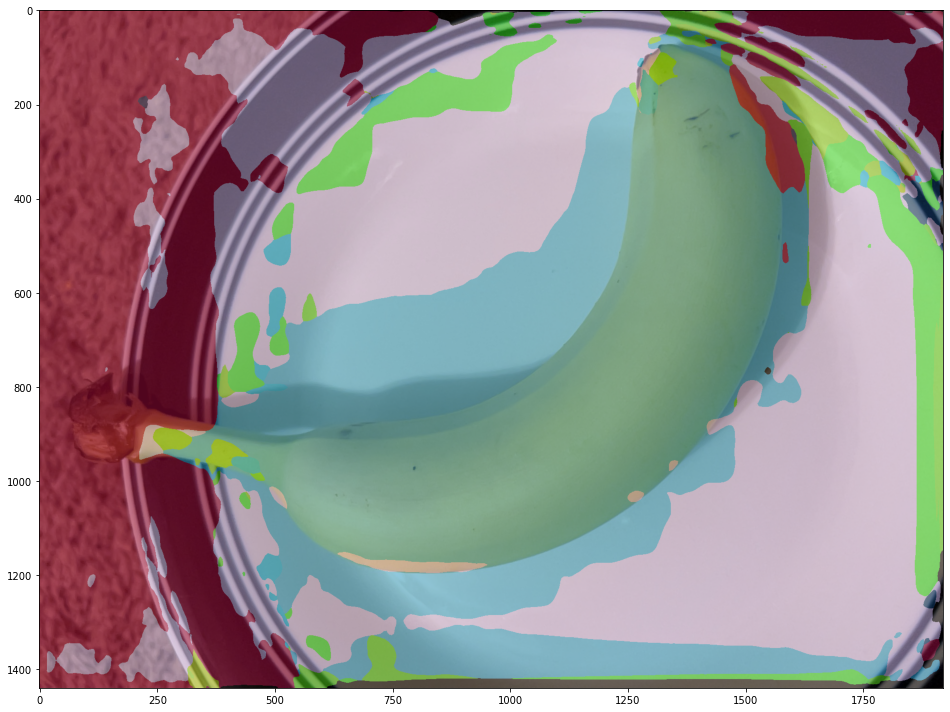

In [61]:
img = mmcv.imread(frame_jpglist[2])
model.cfg = cfg
model.eval()
result = inference_segmentor(model, img)
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, dataset.PALETTE)

In [60]:
import numpy as np
import sys
np.savetxt("hello.txt", result[0], "%-4d")